In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install funpymodeling
!pip install tensorflow

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model
from funpymodeling.exploratory import status, freq_tbl, profiling_num


# https://www.kaggle.com/ronitf/heart-disease-uci
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HeartDesease/heart.csv')

     |████████████████████████████████| 215 kB 4.1 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Exploracion inicial

In [3]:
dataset.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [4]:
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


0 age

1 sex 1-male 0-fem

2 cp - chest pain type

3 trestbps resting blood pressure (in mm Hg on admission to the hospital)

4 chol serum cholestoral in mg/dl

5 fbs (fasting blood sugar &gt; 120 mg/dl) (1 = true; 0 = false)

6 restecg resting electrocardiographic results

7 thalach maximum heart rate achieved

8 exang exercise induced angina (1 = yes; 0 = no)

9 oldpeak ST depression induced by exercise relative to rest

10 slope the slope of the peak exercise ST segment

11 ca number of major vessels (0-3) colored by flourosopy

12 thal 3 = normal; 6 = fixed defect; 7 = reversable defect

13 target 1 or 0


In [6]:
status(dataset)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,age,0,0.0,0,0.000000,41,int64
1,sex,0,0.0,96,0.316832,2,int64
2,cp,0,0.0,143,0.471947,4,int64
3,trestbps,0,0.0,0,0.000000,49,int64
4,chol,0,0.0,0,0.000000,152,int64
5,fbs,0,0.0,258,0.851485,2,int64
6,restecg,0,0.0,147,0.485149,3,int64
7,thalach,0,0.0,0,0.000000,91,int64
8,exang,0,0.0,204,0.673267,2,int64
9,oldpeak,0,0.0,99,0.326733,40,float64


In [7]:
nans = dataset[dataset.isna().sum(axis=1)==1]
print(nans.shape)

(0, 14)


Tengo 14 columnas, no hay filas con valores Nans 

In [8]:
categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numericas = ['age','trestbps', 'chol', 'thalach', 'oldpeak']

# Variable de salida "Target"

(array([138.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 165.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

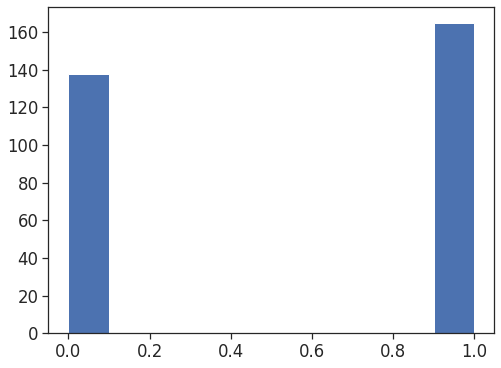

In [9]:
# Analizar la variable de salida
target = dataset.target.to_numpy()
fig, ax = plt.subplots(1,figsize=(8,6))
ax.hist(target)

In [10]:
ds = dataset.copy() #creo una copia del dataset para realizar la ingenieria de features
ds['target'] = ds.target.apply(lambda label: False if (label == 0) else True)
ds.info() # Modifico la variable Target a tipo bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    bool   
dtypes: bool(1), float64(1), int64(12)
memory usage: 31.2 KB


In [11]:
print(ds[ds['target'] == 0].shape)
print(ds[ds['target'] == 1].shape)

(138, 14)
(165, 14)


# Variables Numericas

In [12]:
def show_boxplot(df, variable):
    fig,axes = plt.subplots(1,len(variable),figsize=(22,8),sharex='row',sharey='row')
    for i, var in enumerate(variable):
        sns.boxplot(y=df[var],ax=axes[i])
        
def show_histogram(dt, var):
    fig = dt.hist(xlabelsize=12, ylabelsize=12,figsize=(22,8), bins=50)
    plt.suptitle(var, fontsize=20)
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

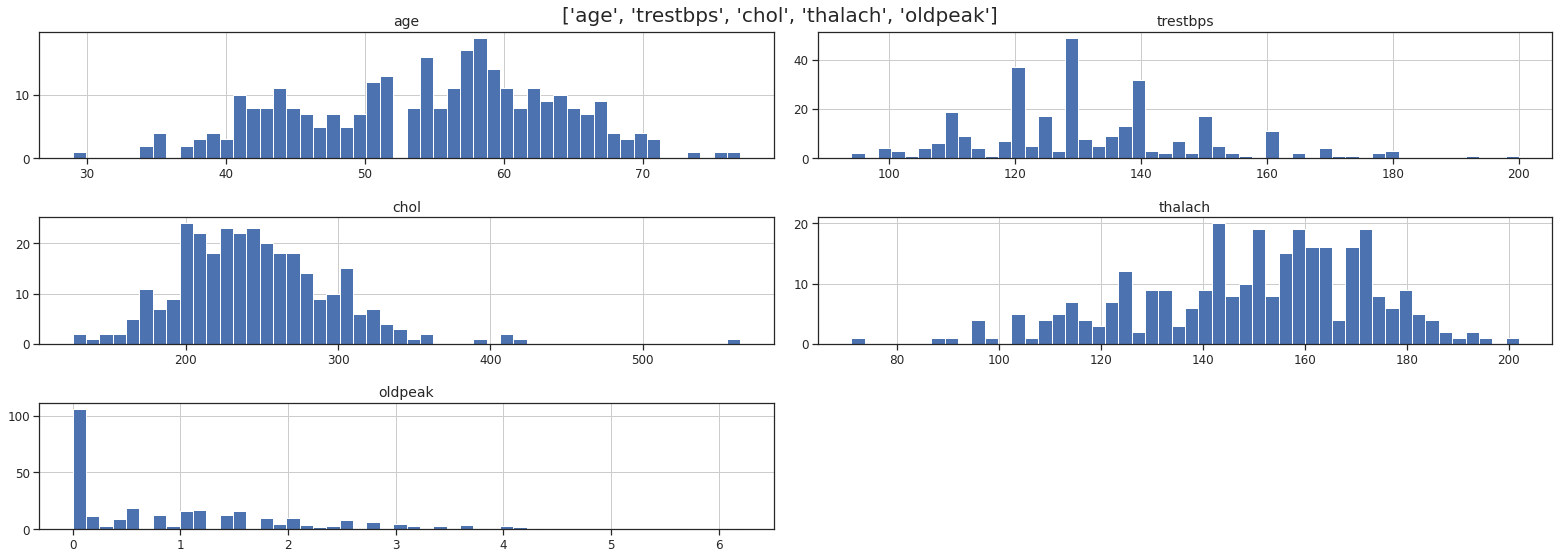

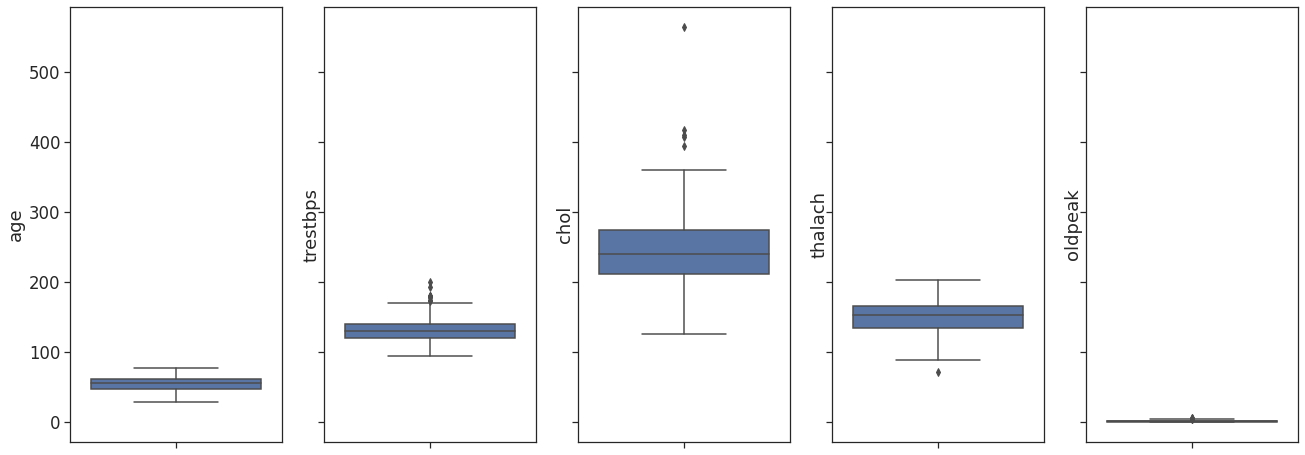

In [13]:
show_histogram(ds[numericas], numericas)
show_boxplot(ds, numericas)

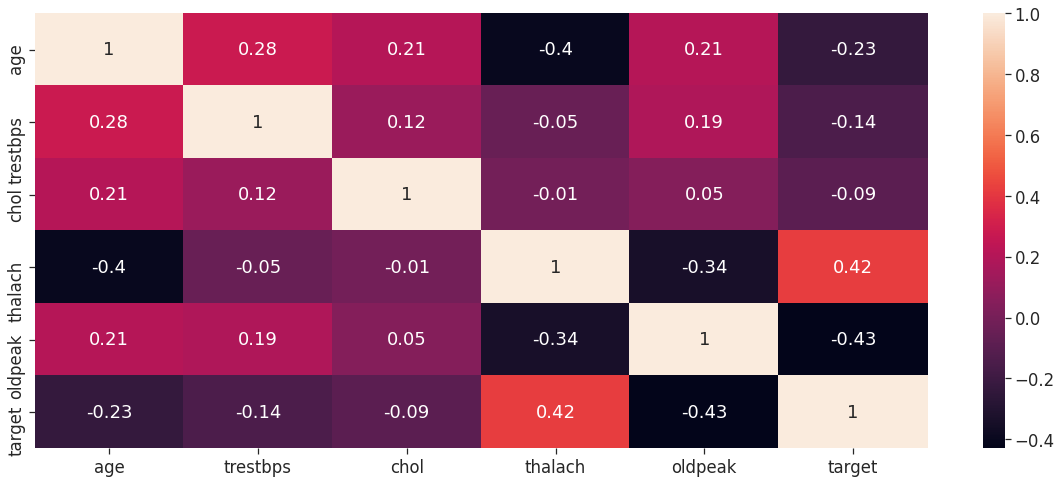

In [14]:
# Matriz de correlación de las variables numericas y variable objetivo, redondeo a 2 decimales
correlation_matrix = ds[['age','trestbps', 'chol', 'thalach', 'oldpeak', 'target']].corr(method='pearson').round(2)
fig,axes = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes);

A continuacion se prueban distintas funciones para ver como afectan a las distribuciones de las variables numericas

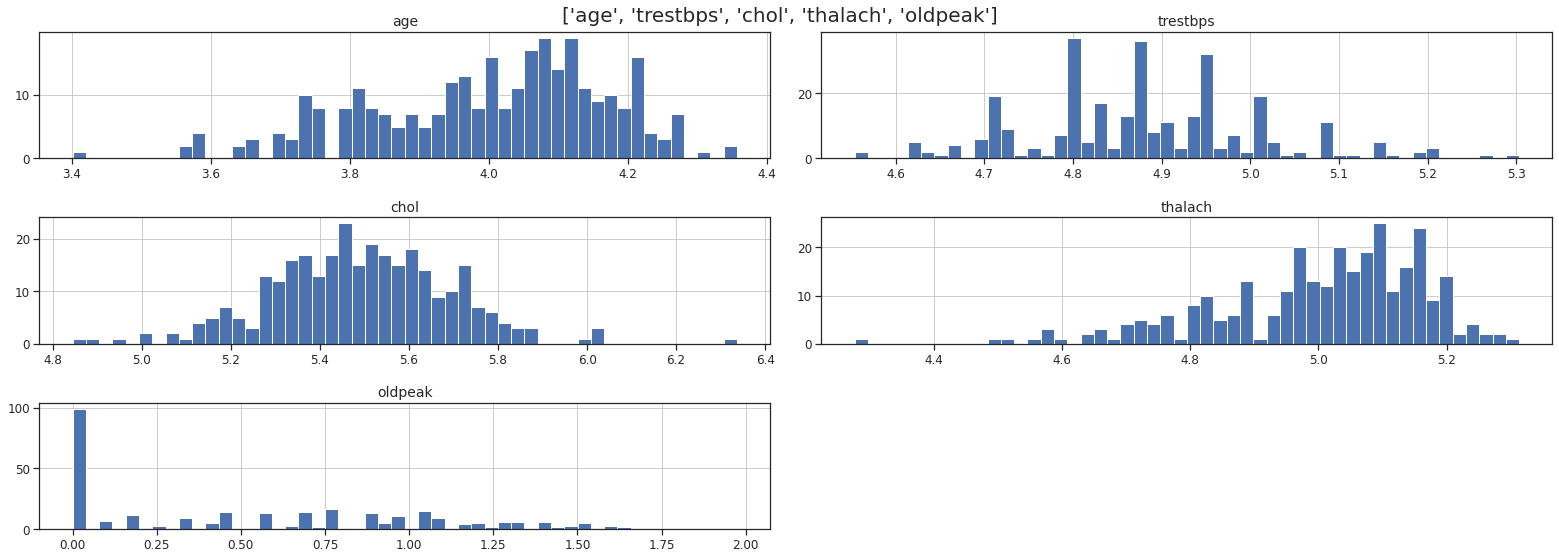

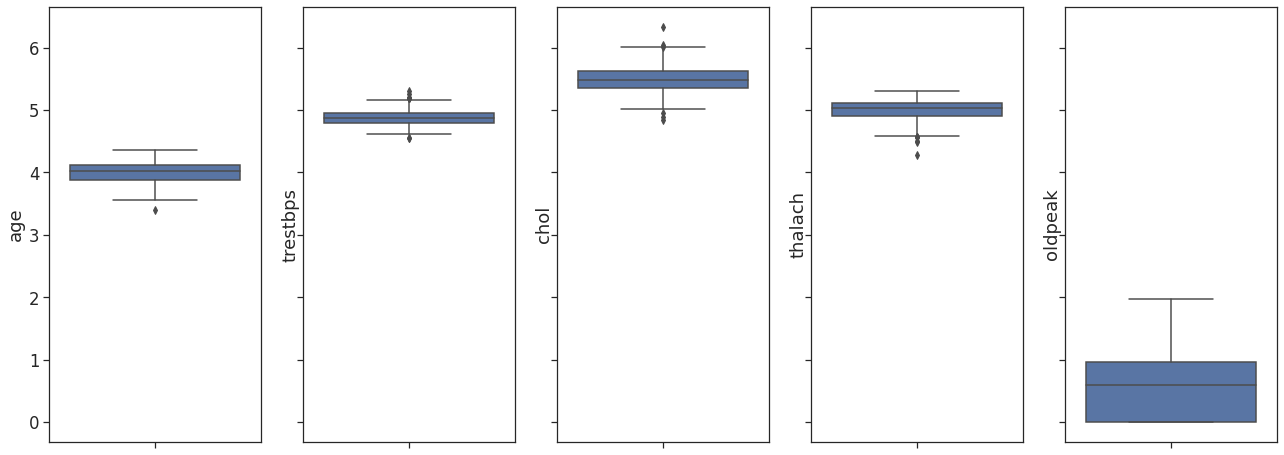

In [15]:
transoform1 = np.log(ds[numericas]+1)
show_histogram(transoform1, numericas)
show_boxplot(transoform1, numericas)

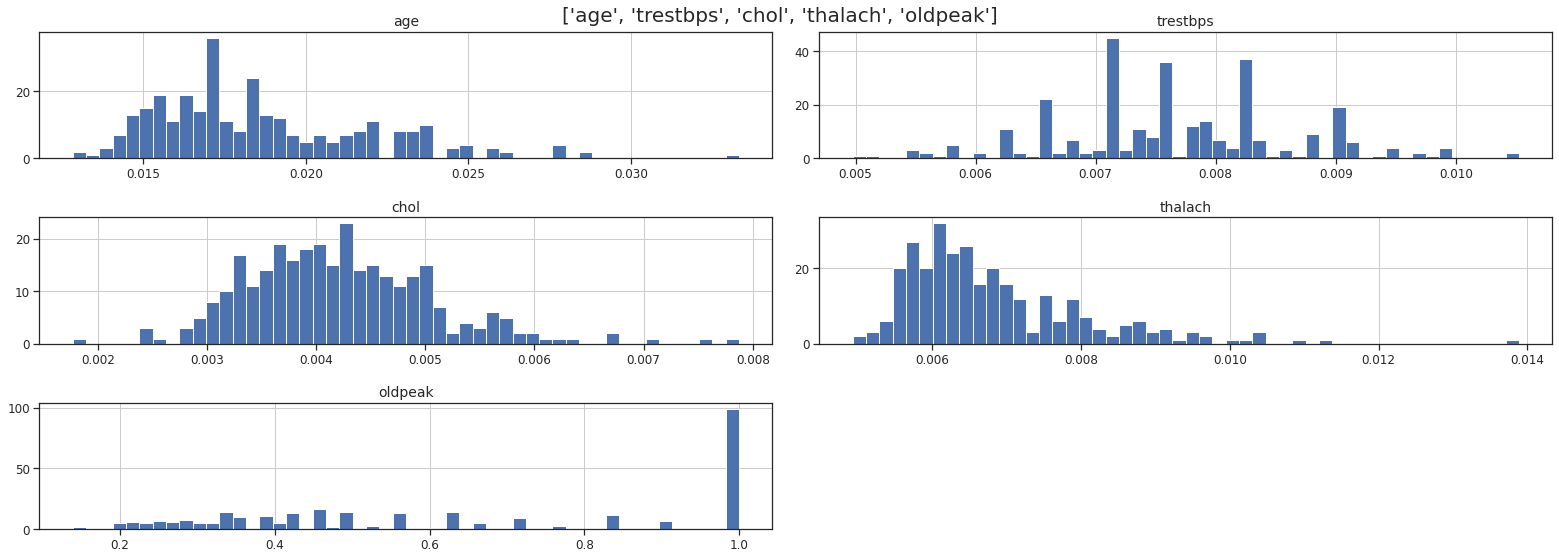

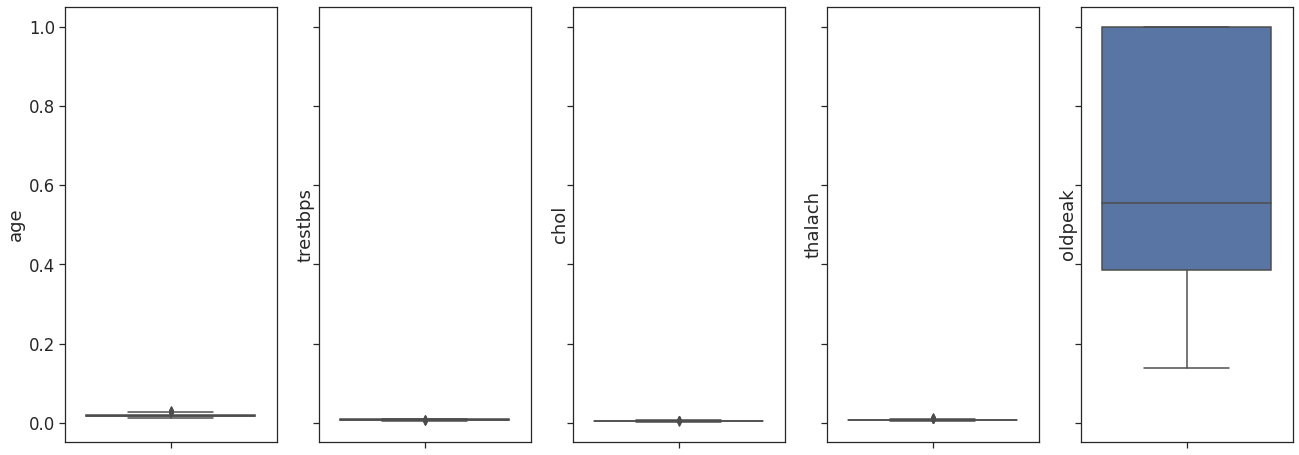

In [16]:
transoform2 = 1/(ds[numericas]+1)
show_histogram(transoform2, numericas)
show_boxplot(transoform2, numericas)

# Variables Categoricas

In [17]:
dataset[categoricas].nunique()

sex        2
cp         4
fbs        2
restecg    3
exang      2
slope      3
ca         5
thal       4
dtype: int64

In [18]:
# Transformo a binarias las variables sex, fbs y exang
ds['sex'] = ds.sex.apply(lambda label: False if (label == 0) else True)
ds['fbs'] = ds.sex.apply(lambda label: False if (label == 0) else True)
ds['exang'] = ds.sex.apply(lambda label: False if (label == 0) else True)

In [19]:
ds.info() # Creo una variable Target de tipo bool

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    bool   
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    bool   
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    bool   
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    bool   
dtypes: bool(4), float64(1), int64(9)
memory usage: 25.0 KB


In [20]:
ds[categoricas].head(5)

,sex,cp,fbs,restecg,exang,slope,ca,thal
0,True,3,True,0,True,0,0,1
1,True,2,True,1,True,0,0,2
2,False,1,False,0,False,2,0,2
3,True,1,True,1,True,2,0,2
4,False,0,False,1,False,2,0,2


(array([  2.,   0.,   0.,  18.,   0.,   0., 166.,   0.,   0., 117.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

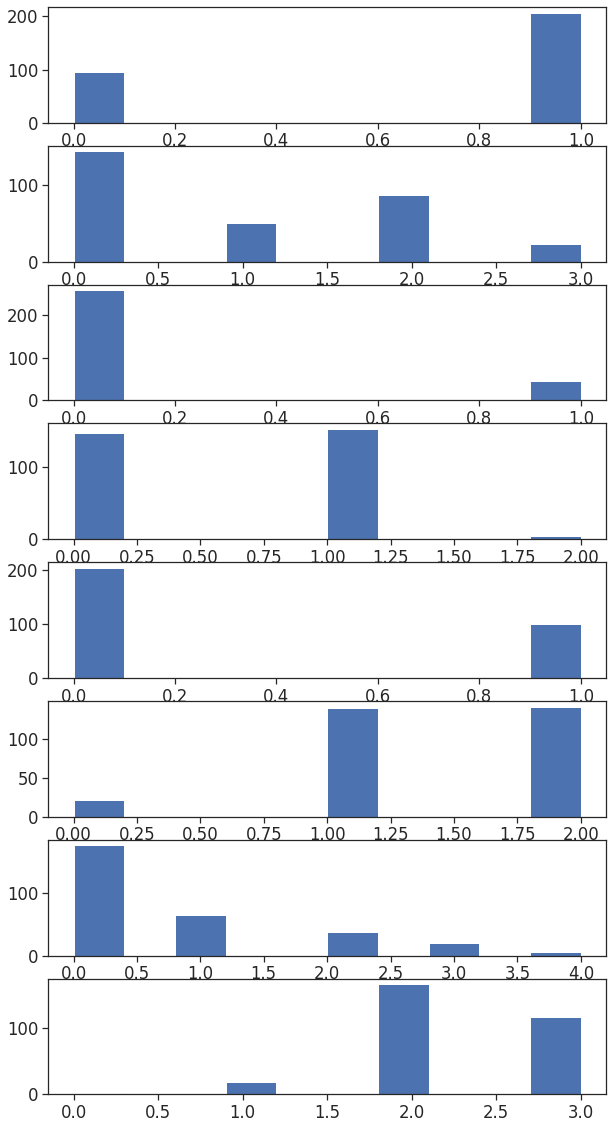

In [21]:
fig, ax = plt.subplots(8,figsize=(10,20))
ax[0].hist(dataset.sex)
ax[1].hist(dataset.cp)
ax[2].hist(dataset.fbs)
ax[3].hist(dataset.restecg)
ax[4].hist(dataset.exang)
ax[5].hist(dataset.slope)
ax[6].hist(dataset.ca)
ax[7].hist(dataset.thal)

In [22]:
# Se elimina la etiqueta 0 de la columna thal ya que era un dato no valido o faltante
ds.drop(ds[ds['thal'] == 0].index, axis = 0, inplace=True)

In [23]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       301 non-null    int64  
 1   sex       301 non-null    bool   
 2   cp        301 non-null    int64  
 3   trestbps  301 non-null    int64  
 4   chol      301 non-null    int64  
 5   fbs       301 non-null    bool   
 6   restecg   301 non-null    int64  
 7   thalach   301 non-null    int64  
 8   exang     301 non-null    bool   
 9   oldpeak   301 non-null    float64
 10  slope     301 non-null    int64  
 11  ca        301 non-null    int64  
 12  thal      301 non-null    int64  
 13  target    301 non-null    bool   
dtypes: bool(4), float64(1), int64(9)
memory usage: 27.0 KB


In [24]:
ds[categoricas].nunique()

sex        2
cp         4
fbs        2
restecg    3
exang      2
slope      3
ca         5
thal       3
dtype: int64

El resto de las variables categoricas se encuentran etiquetadas con valores numericos. Si bien se podria aplicar un one hot encoding en un principio voy a evitarlo debido a que hay muy pocas observaciones. Si realizamos OHE en estas variables el nro de features aumentara pudiendo no resultar un buen dataset. De todos modos el nro de etiquetas o categorias de las distintas variables son similares lo cual permite que tomemos esta decision.

In [25]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       301 non-null    int64  
 1   sex       301 non-null    bool   
 2   cp        301 non-null    int64  
 3   trestbps  301 non-null    int64  
 4   chol      301 non-null    int64  
 5   fbs       301 non-null    bool   
 6   restecg   301 non-null    int64  
 7   thalach   301 non-null    int64  
 8   exang     301 non-null    bool   
 9   oldpeak   301 non-null    float64
 10  slope     301 non-null    int64  
 11  ca        301 non-null    int64  
 12  thal      301 non-null    int64  
 13  target    301 non-null    bool   
dtypes: bool(4), float64(1), int64(9)
memory usage: 27.0 KB


In [26]:
ds.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,True,3,145,233,True,0,150,True,2.3,0,0,1,True
1,37,True,2,130,250,True,1,187,True,3.5,0,0,2,True
2,41,False,1,130,204,False,0,172,False,1.4,2,0,2,True
3,56,True,1,120,236,True,1,178,True,0.8,2,0,2,True
4,57,False,0,120,354,False,1,163,False,0.6,2,0,2,True


# Separacion train y test

In [28]:
# Partición de train-test set. SE QUITAN LOS FEATURES 'Sunshine', 'Evaporation', 'Cloud3pm' y 'Cloud9am':
from sklearn.model_selection import train_test_split


features = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
            'thalach', 'exang','oldpeak', 'slope', 'ca', 'thal']

x_train, x_test, y_train, y_test = train_test_split(
    ds[features], 
    ds['target'],  
    test_size=0.3,
    random_state=42)

In [29]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(210, 13)
(210,)
(91, 13)
(91,)


# Entrenamiento de modelos

In [54]:
# Entrenamiento de modelos de prueba
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Evaluación de modelos de prueba
from sklearn.metrics import balanced_accuracy_score
def pipeline_ml_models(preprocessing_pipeline):
  # Modelos a ensayar.
  models = [
      ("RandomForest", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', RandomForestClassifier(n_estimators=200, random_state=42)) 
          ])
      ),
      
      ("Adaboost", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', AdaBoostClassifier(n_estimators=200, random_state=42)) 
          ])
      ),
      
      ("LogisticRegression", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', LogisticRegression(random_state=42, solver='lbfgs') )
          ])
      ),
      
      ("KNN", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', KNeighborsClassifier(n_neighbors=5) )
          ])
      ),
      
      ("SVM", 
          Pipeline([
              ('preprocessor', preprocessing_pipeline),
              ('model', SVC(random_state=44, probability=True, gamma='auto') )
          ])
      )
  ]
  
  return models

In [83]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# categoricas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
# numericas = ['age','trestbps', 'chol', 'thalach', 'oldpeak']

# Cadena de preprocesamiento

preprocessing_pipeline1 = ColumnTransformer(
    # Transformaciones a aplicar a cada columna
             transformers=[
                           ("numerical", StandardScaler(), numericas)
              ],
              remainder='passthrough'
)
models1 = pipeline_ml_models(preprocessing_pipeline)

In [84]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# categoricas1 = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
categoricas1 = ['cp', 'restecg', 'slope', 'ca', 'thal']
# numericas = ['age','trestbps', 'chol', 'thalach', 'oldpeak']

# Cadena de preprocesamiento

preprocessing_pipeline2 = ColumnTransformer(
    # Transformaciones a aplicar a cada columna
             transformers=[
                           ("numerical", StandardScaler(), numericas),
                           ('categoric1', OneHotEncoder(handle_unknown='ignore'),categoricas1)
              ],
              remainder='passthrough'
)

models2 = pipeline_ml_models(preprocessing_pipeline2)


In [85]:
preprocessing_pipeline3 = ColumnTransformer(
    # Transformaciones a aplicar a cada columna
             transformers=[
                           ("numerical", MinMaxScaler(), numericas)
              ],
              remainder='passthrough'
)

models3 = pipeline_ml_models(preprocessing_pipeline3)

In [86]:
preprocessing_pipeline4 = ColumnTransformer(
    # Transformaciones a aplicar a cada columna
             transformers=[
                           ("numerical", MinMaxScaler(), numericas),
                           ('categoric1', OneHotEncoder(handle_unknown='ignore'),categoricas1)
              ],
              remainder='passthrough'
)

models4 = pipeline_ml_models(preprocessing_pipeline4)

Modelo 1: Se aplica la transformacion StandarScaler en las variable numericas. Las variables categoricas no se modifican

Modelo 2: Se aplica la transformacion StandarScaler en las variable numericas. Se aplica OHE a las variables categoricas no binarias

Modelo 3: Se aplica la transformacion MinMaxScaler en las variable numericas. Las variables categoricas no se modifican

Modelo 4: Se aplica la transformacion MinMaxScaler en las variable numericas. Se aplica OHE a las variables categoricas no binarias

In [87]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import roc_auc_score

def kfold_pipeline(models_pipeline, samples , target, x_test, y_test, k = 5):
    
    """
    Esta funcion recibe:
        models_pipeline: el pipeline de los modelos a evaluar
        samples: set de entrenamiento
        target: salidas del set de entrenamiento
        x_test: set de testeo
        y_test: set de testeo
        k: el numero de segmentos que utilizara el algoritmo de K-Fold
    """
    results = {}
    for model in models_pipeline:
        model_name = model[0]
        results[model_name] = {}
        
        train_auc = 0
        valid_auc = 0
        
        kf = KFold(n_splits=k)
        kf.get_n_splits(samples)
        
        for train_index, valid_index in kf.split(samples, target):
            x_valid = samples.iloc[valid_index]
            y_valid = target.iloc[valid_index]
            x_train = samples.iloc[train_index]
            y_train = target.iloc[train_index]
            
            model[1].fit(x_train, y_train)
            pred_train = model[1].predict_proba(x_train)
            pred_valid = model[1].predict_proba(x_valid)
            
            if len(pred_train.shape)>1 and (pred_train.shape[1]>1):
                train_auc = train_auc + roc_auc_score(y_train, pred_train[:,1]) / k
                valid_auc = valid_auc + roc_auc_score(y_valid, pred_valid[:,1]) / k
            else:
                train_auc = train_auc + roc_auc_score(y_train, pred_train) / k
                valid_auc = valid_auc + roc_auc_score(y_valid, pred_valid) / k
        
        pred_test = model[1].predict_proba(x_test)

        results[model_name]["Train"] = train_auc
        results[model_name]["Valid"] = valid_auc
        results[model_name]["test"] = roc_auc_score(y_test, pred_test[:,1])

    models_results = pd.DataFrame(results).T
    return models_results

In [88]:
res1 = kfold_pipeline(models1, x_train , y_train, x_test, y_test, k = 5)
res2 = kfold_pipeline(models2, x_train , y_train, x_test, y_test, k = 5)
res3 = kfold_pipeline(models3, x_train , y_train, x_test, y_test, k = 5)
res4 = kfold_pipeline(models4, x_train , y_train, x_test, y_test, k = 5)

In [89]:
pd.concat([res1, res2, res3, res4], axis = 1)

,Train,Valid,test,Train,Valid,test,Train,Valid,test,Train,Valid,test
RandomForest,1.000000,0.908538,0.886520,1.000000,0.902552,0.881127,1.000000,0.907846,0.884804,1.000000,0.903007,0.880637
Adaboost,1.000000,0.807821,0.852941,1.000000,0.818800,0.838725,1.000000,0.808739,0.852941,1.000000,0.820630,0.839706
LogisticRegression,0.922610,0.912082,0.903431,0.951664,0.922702,0.896078,0.917962,0.906194,0.897059,0.949185,0.926351,0.891667
KNN,0.945611,0.880345,0.865686,0.957912,0.898199,0.845588,0.957501,0.902701,0.868137,0.959380,0.903465,0.853922
SVM,0.962759,0.903413,0.911275,0.955999,0.914876,0.899020,0.934630,0.910679,0.890196,0.940817,0.915811,0.888235
